In [14]:
import pydub
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from matplotlib.lines import Line2D

In [4]:
y, sr = librosa.load("audio2.wav", sr=None)

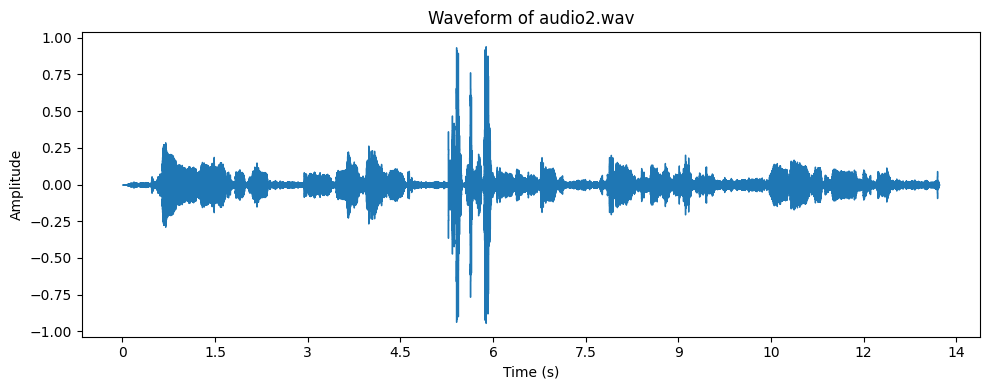

In [5]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of audio2.wav")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

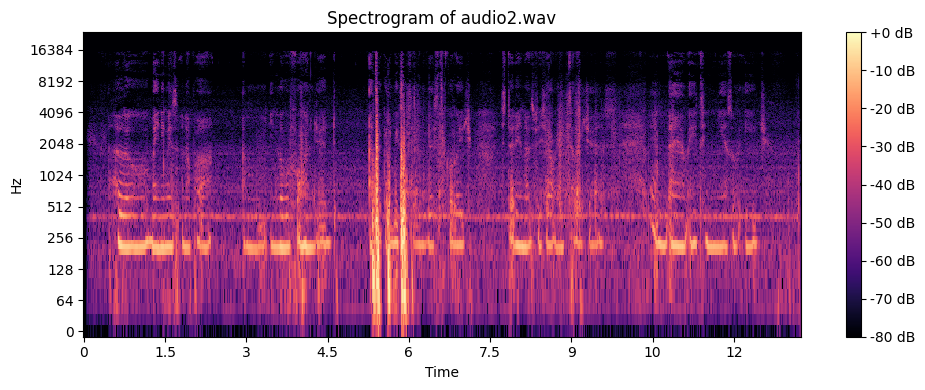

In [6]:
# Compute the Short-Time Fourier Transform (STFT)
D = np.abs(librosa.stft(y))
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of audio2.wav')
plt.tight_layout()
plt.show()

In [12]:
# Frequency component analysis to identify
fft_spectrum = np.fft.fft(y)
freq = np.fft.fftfreq(len(fft_spectrum), 1/sr)
magnitude = np.abs(fft_spectrum)


# Separate frequency bands for analysis
fricative_mask = np.abs(freq) > 4000  # High frequencies for fricatives/consonants
vowel_mask = np.abs(freq) < 1000      # Low frequencies for vowels



# Get corresponding magnitudes
fricative_magnitudes = magnitude[fricative_mask]
vowel_magnitudes = magnitude[vowel_mask]
fricative_freqs = freq[fricative_mask]
vowel_freqs = freq[vowel_mask]



# Find peak frequencies in each band (formants for vowels)
fricative_peaks = np.argsort(fricative_magnitudes)[-5:]  # Top 5 peaks
vowel_peaks = np.argsort(vowel_magnitudes)[-5:]         # Top 5 peaks



print(f"Top fricative/consonant frequencies: {fricative_freqs[fricative_peaks]}")
print(f"Top vowel formant frequencies: {vowel_freqs[vowel_peaks]}")
freq = np.fft.fftfreq(len(fft_spectrum), 1/sr)
magnitude = np.abs(fft_spectrum)


Top fricative/consonant frequencies: [-4726.28528226 -4834.1733871   4834.1733871   4772.78225806
 -4772.78225806]
Top vowel formant frequencies: [-209.04737903  207.91330645 -207.91330645 -209.50100806  209.50100806]


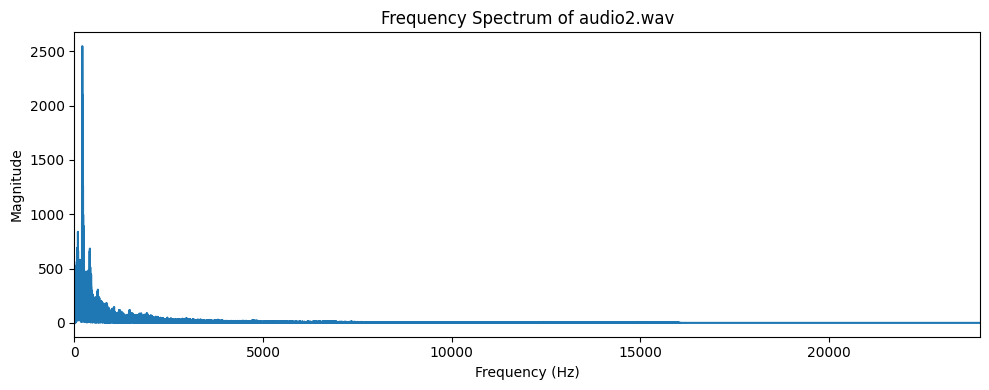

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(freq[:len(freq)//2], magnitude[:len(magnitude)//2])
plt.title("Frequency Spectrum of audio2.wav")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sr/2)
plt.tight_layout()
plt.show()

In [18]:
# Calculate mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

In [20]:
# Simplified phonetic region detection
def detect_phonetic_regions(y, sr, hop_length=512):
    # Extract features
    energy = np.sum(librosa.feature.rms(y=y, hop_length=hop_length)**2, axis=0)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0]
    
    # Normalize features
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy) + 1e-10)
    cent = (cent - np.min(cent)) / (np.max(cent) - np.min(cent) + 1e-10)
    zcr = (zcr - np.min(zcr)) / (np.max(zcr) - np.min(zcr) + 1e-10)
    
    # Classify regions
    vowel_mask = (energy > 0.3) & (zcr < 0.5) & (cent < 0.5)
    fricative_mask = (energy > 0.2) & (zcr > 0.6) & (cent > 0.6)
    
    # Detect stops (low energy followed by burst)
    stop_mask = np.zeros_like(energy, dtype=bool)
    energy_diff = np.diff(energy, prepend=0)
    stop_mask[:-1] = (energy[:-1] < 0.2) & (energy_diff[1:] > 0.3)
    
    times = librosa.times_like(energy, sr=sr, hop_length=hop_length)
    return times, vowel_mask, fricative_mask, stop_mask


# Detect phonetic regions and plot results
times, vowel_mask, fricative_mask, stop_mask = detect_phonetic_regions(y, sr)

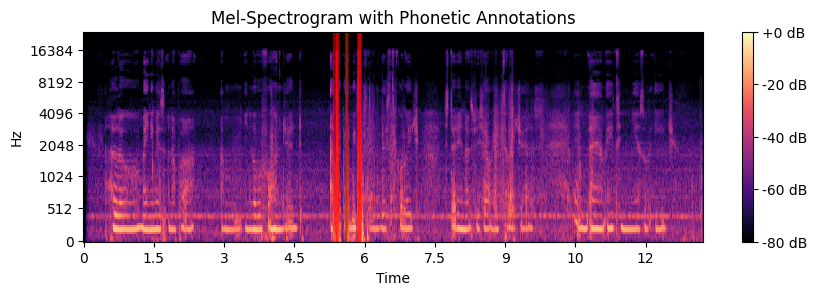

In [21]:

plt.figure(figsize=(10, 6))

# Plot spectrogram with annotations
plt.subplot(2, 1, 1)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram with Phonetic Annotations')

# Add phonetic region highlights
for mask, color in [(vowel_mask, 'red'), (fricative_mask, 'blue'), (stop_mask, 'green')]:
    for i in range(len(times)):
        if mask[i]:
            plt.axvline(x=times[i], color=color, alpha=0.3)


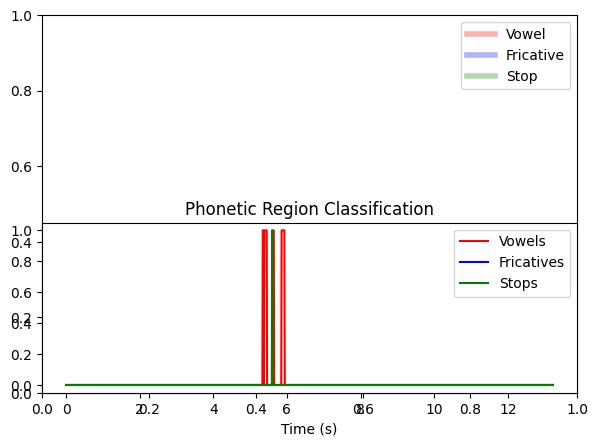

Vowels: 1.69% of audio
Fricatives: 0.00% of audio
Stops: 0.08% of audio


In [22]:
# Add legend
legend_elements = [
    Line2D([0], [0], color=c, lw=4, alpha=0.3, label=l) 
    for c, l in zip(['red', 'blue', 'green'], ['Vowel', 'Fricative', 'Stop'])
]
plt.legend(handles=legend_elements, loc='upper right')

# Plot phonetic classifications
plt.subplot(2, 1, 2)
plt.plot(times, vowel_mask.astype(int), 'r-', label='Vowels')
plt.plot(times, fricative_mask.astype(int), 'b-', label='Fricatives')
plt.plot(times, stop_mask.astype(int), 'g-', label='Stops')
plt.title('Phonetic Region Classification')
plt.xlabel('Time (s)')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary
for region, mask in [("Vowels", vowel_mask), ("Fricatives", fricative_mask), ("Stops", stop_mask)]:
    print(f"{region}: {np.mean(mask)*100:.2f}% of audio")

In [24]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectraL_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)


mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

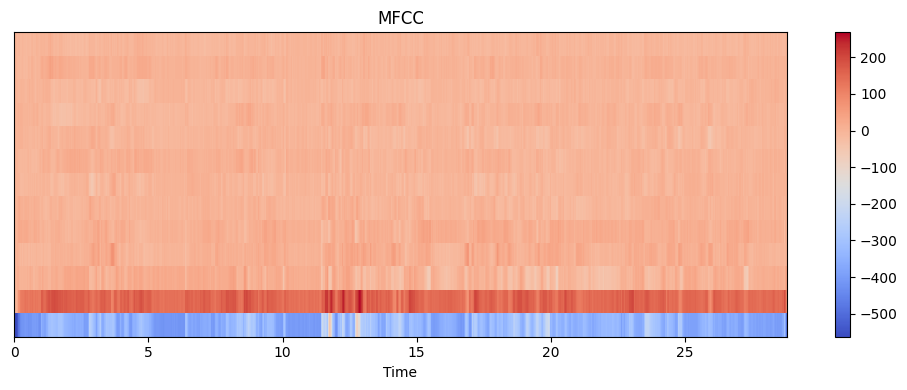

In [25]:
# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

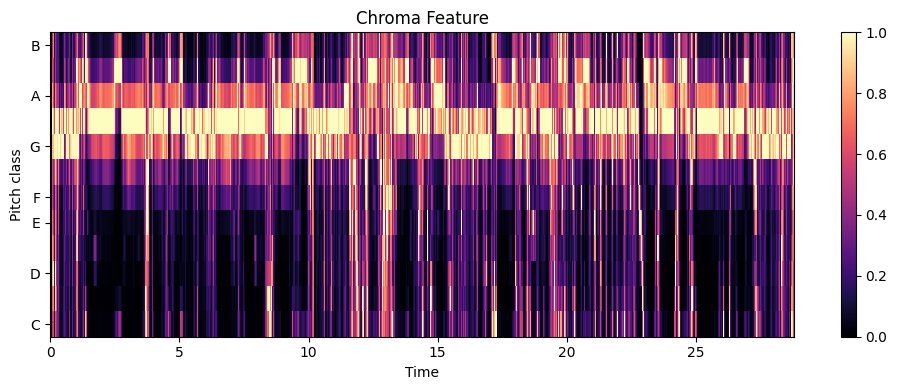

In [26]:
# Plot Chroma
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Feature') 
plt.tight_layout()
plt.show()

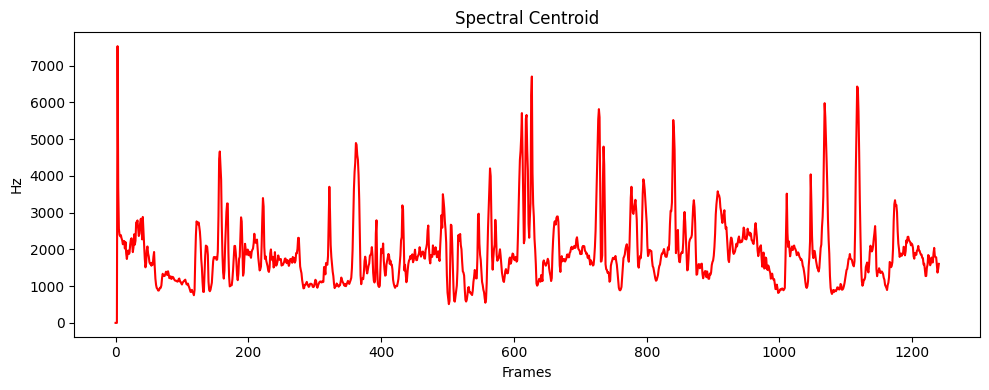

In [27]:
# Plot Spectral Centroid
plt.figure(figsize=(10, 4))     
plt.plot(spectraL_centroid[0], color='r')
plt.title('Spectral Centroid')
plt.xlabel('Frames')
plt.ylabel('Hz')
plt.tight_layout()
plt.show()

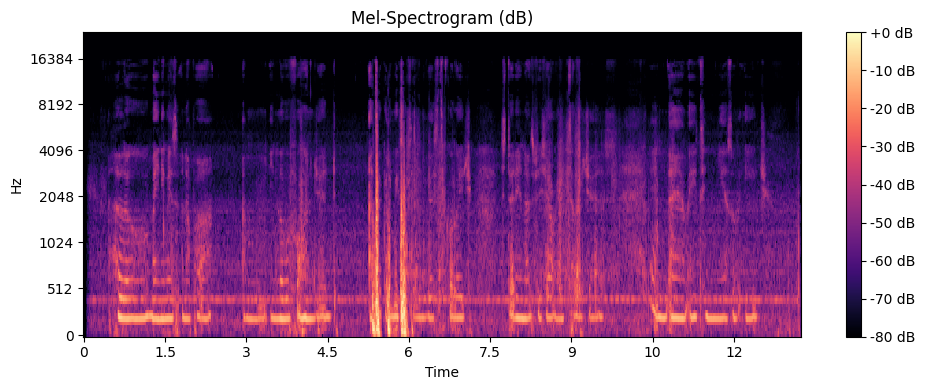

In [28]:
# Plot Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (dB)')
plt.tight_layout()
plt.show()